In [19]:
# 맥 한글 설정

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# 1. 한글 폰트 설정
if platform.system() == 'Darwin':  # Mac
    plt.rcParams['font.family'] = 'AppleGothic'
elif platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:  # Linux (예: colab)
    plt.rcParams['font.family'] = 'NanumGothic'

# 2. 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [20]:
import pandas as pd
import numpy as np

In [22]:
df = pd.read_csv('스마트팜_수정데이터.csv', encoding='euc-kr')

In [23]:
# 필요없는 컬럼 제거
df1 = df.drop(['체세포', '축종코드', '제조사 아이디', '수집건수', '측정일시'], axis=1)

In [24]:
# 농장아이디, 개체번호 카테고리화
df1['개체번호'] = df1['개체번호'].astype('category')
df1['농장아이디'] = df1['농장아이디'].astype('category')

In [25]:
# 혈액흐름 인코딩
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
df1['혈액흐름'] = encoder.fit_transform(df1[['혈액흐름']])

In [26]:
# 유단백 대비 유지방 컬럼 생성
df1['PFR'] = round(df1['유단백'] / df1['유지방'], 3)

In [27]:
# 착유 소요 시간 컬럼 생성
df1['착유시작일시'] = pd.to_datetime(df1['착유시작일시'], format='%Y-%m-%d %H:%M')
df1['착유종료일시'] = pd.to_datetime(df1['착유종료일시'], format='%Y-%m-%d %H:%M')
df1['착유소요시간(분)'] = (df1['착유종료일시'] - df1['착유시작일시']).dt.total_seconds()/60

In [9]:
# 결측값 제거
df1 = df1.dropna()

### 이상탐지

#### one-class SVM

In [ ]:
# 이상탐지에 사용할 컬럼

columns = ['전도도', '온도', '유지방', '유단백', '공기흐름', '착유소요시간(분)']
detect_outlier = df1[columns].copy()

In [11]:
# one class SVM 이전 스케일링

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
detect_outlier_scaled = scaler.fit_transform(detect_outlier)

In [12]:
# one class SVM

from sklearn.svm import OneClassSVM

svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)
y_pred_svm = svm.fit_predict(detect_outlier_scaled)

detect_outlier['outliers_svm'] = y_pred_svm

In [13]:
# 이상치로 예측된 샘플 인덱스 추출
outliers_svm = np.where(y_pred_svm == -1)[0]

print('=== One Class SVM ===')
print('이상치로 탐지된 샘플 개수: ', len(outliers_svm))
print('이상치 인덱스: ', outliers_svm)

=== One Class SVM ===
이상치로 탐지된 샘플 개수:  317
이상치 인덱스:  [   54    58    59   235   406   445   451   585   859   867   869   870
   891   897   950   951   952   953   954   955   956   957   958   961
   962   973  1264  1397  1429  1431  1469  1751  1752  1753  1754  1755
  1756  1759  1761  1793  1794  1795  1797  1800  1908  1967  2502  2503
  2532  2533  2544  2545  2578  2579  3254  3255  3806  3807  3830  3831
  4194  4195  4220  4221  4226  4227  4228  4229  4508  4509  4518  4519
  4554  4555  4622  4623  4706  4707  5266  5267  5370  5371  5388  5389
  5408  5409  5606  5607  5832  5833  5834  5835  6800  6801  7086  7087
  7134  7135  7144  7145  7350  7351  7706  7707  8722  8723  8910  8911
  9248  9249  9250  9251  9258  9259  9268  9269  9324  9325  9474  9475
  9488  9489  9494  9495 11614 11615 12244 12245 12262 12263 12264 12265
 12274 12275 12280 12281 12306 12307 12322 12323 12748 12749 12980 12981
 12982 12983 13132 13133 13176 13177 13186 13187 13190 13191 13192 1319

In [14]:
# 다변량이기에 시각화를 위해 PCA 차원 축소

from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(detect_outlier_scaled)

# 결과를 원래 DataFrame에 추가
detect_outlier['pca1'] = pca_result[:, 0]
detect_outlier['pca2'] = pca_result[:, 1]

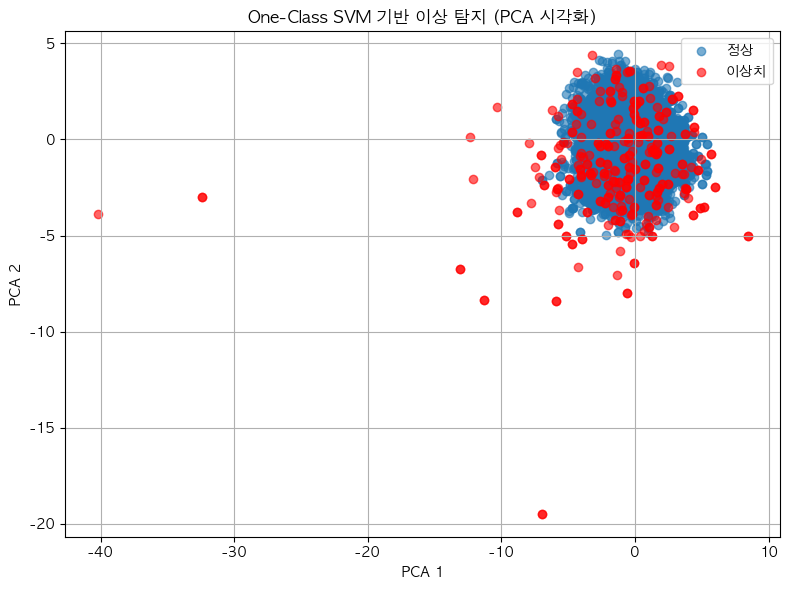

In [15]:
# 시각화

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(
    detect_outlier[detect_outlier['outliers_svm'] == 1]['pca1'],
    detect_outlier[detect_outlier['outliers_svm'] == 1]['pca2'],
    label='정상', alpha=0.6
)
plt.scatter(
    detect_outlier[detect_outlier['outliers_svm'] == -1]['pca1'],
    detect_outlier[detect_outlier['outliers_svm'] == -1]['pca2'],
    label='이상치', color='red', alpha=0.6
)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('One-Class SVM 기반 이상 탐지 (PCA 시각화)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

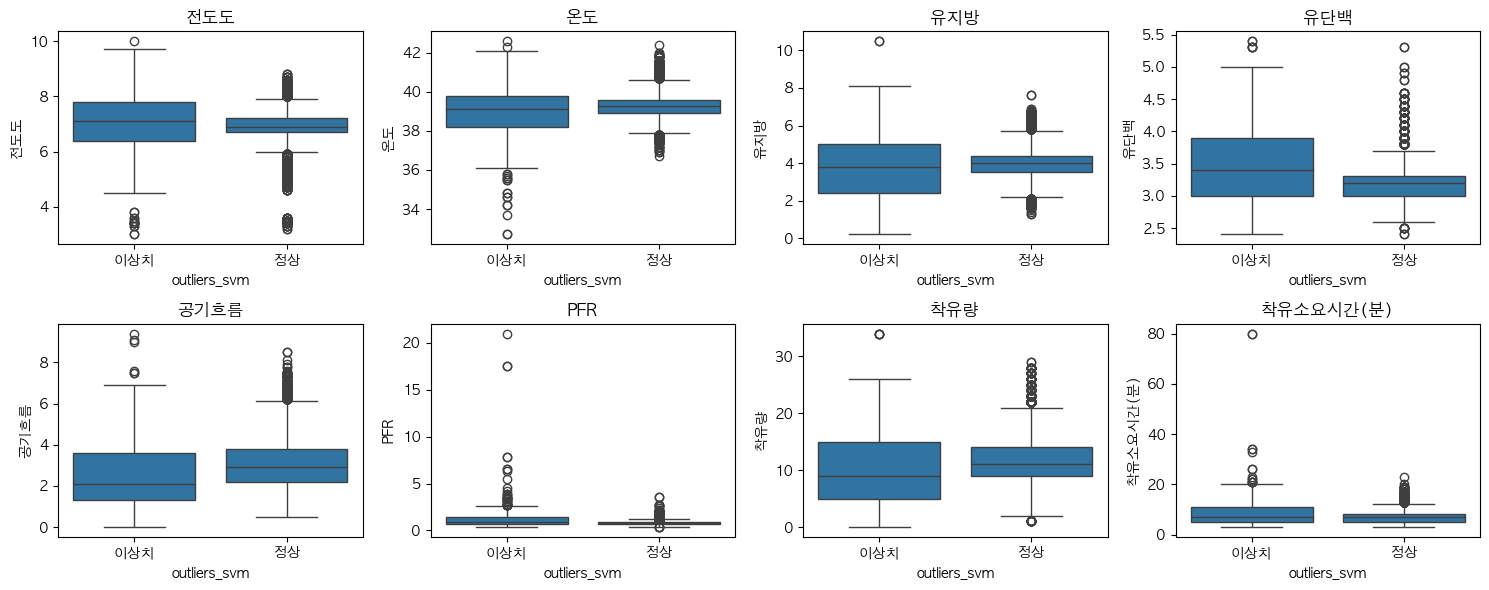

In [16]:
# box plot 시각화

import seaborn as sns

# 정상과 이상치 분리
normal_df = detect_outlier[detect_outlier['outliers_svm'] == 1]
outlier_df = detect_outlier[detect_outlier['outliers_svm'] == -1]

# boxplot 비교
plt.figure(figsize=(15, 6))
for i, feature in enumerate(columns):
    plt.subplot(2, (len(columns) + 1) // 2, i + 1)
    sns.boxplot(data=detect_outlier, x='outliers_svm', y=feature)
    plt.xticks([0, 1], ['이상치', '정상'])
    plt.title(feature)
plt.tight_layout()
plt.show()

In [17]:
# 이상탐지 후 정상 데이터만으로 착유량 예측

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

df_clean = detect_outlier[detect_outlier['outliers_svm'] == 1].copy()

feature_cols = ['전도도', '온도', '유지방', '유단백', '공기흐름', 'PFR', '착유소요시간(분)']
X = df_clean[feature_cols]
y = df_clean['착유량']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"- RMSE: {rmse:.3f}\n- R² Score: {r2:.3f}")

- RMSE: 1.569
- R² Score: 0.820


In [18]:
# 분포 확인
df_clean.describe()

,전도도,온도,유지방,유단백,공기흐름,PFR,착유량,착유소요시간(분),outliers_svm,pca1,pca2
count,27557.000000,27557.000000,27557.000000,27557.000000,27557.000000,27557.000000,27557.000000,27557.000000,27557.0,27557.000000,27557.000000
mean,6.905730,39.296393,3.960369,3.161864,3.073760,0.829591,11.609029,6.935370,1.0,0.015711,0.017125
std,0.549741,0.568315,0.736897,0.207192,1.121462,0.186660,3.634681,2.137679,0.0,1.321251,1.257583
min,3.200000,36.700000,1.300000,2.400000,0.500000,0.364000,1.000000,3.000000,1.0,-6.959405,-4.955631
25%,6.700000,38.900000,3.500000,3.000000,2.200000,0.707000,9.000000,5.000000,1.0,-0.753391,-0.802831
50%,6.900000,39.300000,4.000000,3.200000,2.900000,0.800000,11.000000,7.000000,1.0,0.144963,0.079424
75%,7.200000,39.600000,4.400000,3.300000,3.800000,0.914000,14.000000,8.000000,1.0,0.896188,0.898067
max,8.800000,42.400000,7.600000,5.300000,8.500000,3.538000,29.000000,23.000000,1.0,5.400529,4.425373
